In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

## CSVDataProcessor

### Features
1. **Load Latest Data**: Automatically loads the latest CSV file for a given stock code from the `./data` directory.
2. **Retrieve Specific Columns**: Fetch data from specific columns such as `Close`, `High`, `Low`, etc.
3. **Get Recent Data**: Retrieve the last `n` days of data from the loaded dataset.
4. **Calculate High and Low**: Find the highest and lowest values for the last 30 days.
5. **Print Summary**: Display a statistical summary of the data, including mean, max, min, etc.

## Initialization
To initialize the `CSVDataProcessor` class:
```python
processor = CSVDataProcessor(stock_code="0050")

In [2]:
class CSVDataProcessor:
    def __init__(self, stock_code, start_date=None, end_date=None):
        self.stock_code = stock_code
        self.filename = None
        self.data = None
        self.load_latest_data()

    def load_latest_data(self):
        file_pattern = f'./data/{self.stock_code}_*.csv'
        files = sorted([file for file in os.listdir('./data') if file.startswith(self.stock_code) and file.endswith('.csv')], reverse=True)
        
        if files:
            self.filename = os.path.join('./data', files[0])
            self.data = pd.read_csv(self.filename, parse_dates=['Date'], index_col=0)
            self.data.sort_values(by='Date', inplace=True)
        else:
            print(f"No data found for stock code: {self.stock_code}")
            self.filename = None
            self.data = None

    def get_column(self, column_name):
        if self.data is not None and column_name in self.data.columns:
            return self.data[column_name]
        else:
            print(f"Column '{column_name}' not found in the data.")
            return None

    def get_last_n_days(self, n):
        if self.data is not None:
            return self.data.tail(n)
        else:
            print("No data available.")
            return None

    def get_30_days_high_low(self):
        if self.data is not None:
            last_30_days = self.get_last_n_days(30)
            high = last_30_days['High'].max() if 'High' in last_30_days.columns else None
            low = last_30_days['Low'].min() if 'Low' in last_30_days.columns else None
            return high, low
        else:
            print("No data available.")
            return None, None

    def print_summary(self):
        if self.data is not None:
            print(f"Data Summary for {self.stock_code}:")
            print(self.data.describe())
            
            print("\nData Time Range:")
            print(f"Start Date: {self.data['Date'].min()}")
            print(f"End Date: {self.data['Date'].max()}")
        else:
            print("No data available for summary.")

In [3]:
class ChartVisualizer:
    def __init__(self, data, stock_code):
        self.data = data
        self.stock_code = stock_code


    def plot_with_signals(self, indicator_column, buy_signal='Buy', sell_signal='Sell',
                                      buy_threshold=None, sell_threshold=None):
        if self.data is None or indicator_column not in self.data.columns:
            print(f"Data or indicator column '{indicator_column}' is missing.")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

        ax1.plot(self.data.index, self.data['Close'], label='Close Price', color='blue', linewidth=0.8)
        ax1.set_title(f"Stock Price with Signals ({self.stock_code})")
        ax1.set_ylabel("Price")
        if 'Signal' in self.data.columns:
            buy_signals = self.data[self.data['Signal'] == buy_signal]
            sell_signals = self.data[self.data['Signal'] == sell_signal]
            ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
            ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
        ax1.legend()

        ax2.plot(self.data.index, self.data[indicator_column], label=indicator_column, color='orange', linewidth=0.8)
        if buy_threshold is not None:
            ax2.axhline(buy_threshold, color='green', linestyle='--', linewidth=0.8, label=f'Buy Threshold ({buy_threshold})')
        if sell_threshold is not None:
            ax2.axhline(sell_threshold, color='red', linestyle='--', linewidth=0.8, label=f'Sell Threshold ({sell_threshold})')
        ax2.set_title(f"{indicator_column} with Thresholds")
        ax2.set_ylabel(f"{indicator_column} Value")
        ax2.legend()

        plt.tight_layout()
        plt.show()


# Relative Strength Index (RSI)

## Formula
RSI is calculated using the following formula:

$$
RSI = 100 - \frac{100}{1 + RS}
$$

Where:

$$
RS = \frac{\text{Average Gain over N periods}}{\text{Average Loss over N periods}}
$$

- **Average Gain**: The average of all positive price changes over the selected period (e.g., 14 days).
- **Average Loss**: The average of all negative price changes over the same period.

In [4]:
class RSIAnalyzer:
    def __init__(self, data, period=14):
        self._data = data.copy()
        self.period = period
        self._rsi_data = None
        self._cumulative_return = 0.0
        self._trade_count = 0
        self.calculate_rsi()

    def calculate_rsi(self):
        if self._data is None or 'Close' not in self._data.columns:
            print("Data is missing or 'Close' column is not present.")
            return None
        
        df = self._data
        df['Change'] = df['Close'].diff()
        df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
        df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)
        df['AvgGain'] = df['Gain'].rolling(window=self.period, min_periods=1).mean()
        df['AvgLoss'] = df['Loss'].rolling(window=self.period, min_periods=1).mean()
        df['RS'] = df['AvgGain'] / df['AvgLoss']
        df['RSI'] = 100 - (100 / (1 + df['RS']))

        self._rsi_data = df[['Close', 'RSI']].copy()
        return self._rsi_data
        
    def apply_strategy(self, buy_threshold=20, sell_threshold=80, plot=True):

        if self._rsi_data is None:
            print("RSI data is not available. Please calculate RSI first.")
            return None

        df = self._rsi_data.copy()
        df['Signal'] = None
        df['Trade_Return'] = None
        df['Cumulative_Return'] = 0.0

        buy_price = None

        for index, row in df.iterrows():
            if row['RSI'] < buy_threshold:
                df.at[index, 'Signal'] = 'Buy'
                buy_price = row['Close']
            elif row['RSI'] > sell_threshold and buy_price is not None:
                df.at[index, 'Signal'] = 'Sell'
                sell_price = row['Close']
                trade_return = (sell_price - buy_price) / buy_price * 100
                self._cumulative_return += trade_return
                self._trade_count += 1
                df.at[index, 'Trade_Return'] = trade_return
                df.at[index, 'Cumulative_Return'] = self._cumulative_return
                buy_price = None

        if plot:
            self.plot_result(df, buy_threshold, sell_threshold)
        self.show_result()

        return df[['Close', 'RSI', 'Signal', 'Trade_Return', 'Cumulative_Return']]

    def show_result(self):
        print("\n=== RSI Strategy Summary ===")
        print(f"Total Trades: {self._trade_count}")
        print(f"Cumulative Return: {self._cumulative_return:.2f}%")
        if self._trade_count > 0:
            avg_return = self._cumulative_return / self._trade_count
            print(f"Average Return per Trade: {avg_return:.2f}%")
        else:
            print("No trades executed.")

    def plot_result(self, df, buy_threshold=None, sell_threshold=None):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.8)
        buy_signals = df[df['Signal'] == 'Buy']
        sell_signals = df[df['Signal'] == 'Sell']
        ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
        ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
        ax1.set_title("RSI Strategy - Price and Signals")
        ax1.set_ylabel("Price")
        ax1.legend()

        ax2.plot(df.index, df['RSI'], label='RSI', color='orange', linewidth=0.8)
        if buy_threshold is not None:
            ax2.axhline(buy_threshold, color='green', linestyle='--', label=f'Buy Threshold ({buy_threshold})')
        if sell_threshold is not None:
            ax2.axhline(sell_threshold, color='red', linestyle='--', label=f'Sell Threshold ({sell_threshold})')
        ax2.set_title("RSI Indicator")
        ax2.set_ylabel("RSI Value")
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [5]:
class KDAnalyzer:
    def __init__(self, data, n=9, m=3):
        self._data = data.copy()
        self.n = n
        self.m = m
        self._kd_data = None
        self._trade_count = 0
        self._cumulative_return = 0.0
        self.calculate_kd()

    def calculate_kd(self):
        if self._data is None or not {'Close', 'High', 'Low'}.issubset(self._data.columns):
            print("Data is missing or required columns ('Close', 'High', 'Low') are not present.")
            return None
        
        df = self._data
        df['Lowest_Low'] = df['Low'].rolling(window=self.n, min_periods=1).min()
        df['Highest_High'] = df['High'].rolling(window=self.n, min_periods=1).max()

        df['Range'] = df['Highest_High'] - df['Lowest_Low']
        df['Range'] = df['Range'].replace(0, 1) 

        df['%K'] = (df['Close'] - df['Lowest_Low']) / df['Range'] * 100
        df['%D'] = df['%K'].rolling(window=self.m, min_periods=1).mean()

        self._kd_data = df[['Close', '%K', '%D']].copy() 
        return self._kd_data
    
    def apply_strategy(self, buy_threshold=20, sell_threshold=80, cooldown_days=5, plot=True):

        if self._kd_data is None:
            print("Please calculate KD first.")
            return None

        df = self._kd_data.copy()
        df['Signal'] = None
        df['Trade_Return'] = None
        df['Cumulative_Return'] = 0.0

        buy_price = None
        cooldown_counter = 0

        for index, row in df.iterrows():
            if cooldown_counter > 0:
                cooldown_counter -= 1
                continue

            if row['%K'] < buy_threshold and row['%K'] > row['%D']:
                df.at[index, 'Signal'] = 'Buy'
                buy_price = row['Close']
                cooldown_counter = cooldown_days 

            elif row['%K'] > sell_threshold and row['%K'] < row['%D'] and buy_price is not None:
                df.at[index, 'Signal'] = 'Sell'
                sell_price = row['Close']
                trade_return = (sell_price - buy_price) / buy_price * 100
                self._cumulative_return += trade_return
                self._trade_count += 1
                df.at[index, 'Trade_Return'] = trade_return
                df.at[index, 'Cumulative_Return'] = self._cumulative_return
                buy_price = None
                cooldown_counter = cooldown_days
            
        if plot:
            self.plot_result(df, buy_threshold, sell_threshold)
        self.show_result()

        return df[['Close', '%K', '%D', 'Signal', 'Trade_Return', 'Cumulative_Return']]
        

    def show_result(self):
        print("\n=== KD Strategy Summary ===")
        print(f"Total Trades: {self._trade_count}")
        print(f"Cumulative Return: {self._cumulative_return:.2f}%")
        if self._trade_count > 0:
            avg_return = self._cumulative_return / self._trade_count
            print(f"Average Return per Trade: {avg_return:.2f}%")
        else:
            print("No trades executed.")

    def plot_result(self, df, buy_threshold=None, sell_threshold=None):

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.8)
        buy_signals = df[df['Signal'] == 'Buy']
        sell_signals = df[df['Signal'] == 'Sell']
        ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
        ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
        ax1.set_title("KD Strategy - Price and Signals")
        ax1.set_ylabel("Price")
        ax1.legend()

        ax2.plot(df.index, df['%K'], label='%K', color='orange', linewidth=0.8)
        ax2.plot(df.index, df['%D'], label='%D', color='purple', linewidth=0.8)
        if buy_threshold is not None:
            ax2.axhline(buy_threshold, color='green', linestyle='--', label=f'Buy Threshold ({buy_threshold})')
        if sell_threshold is not None:
            ax2.axhline(sell_threshold, color='red', linestyle='--', label=f'Sell Threshold ({sell_threshold})')
        ax2.set_title("KD Indicator")
        ax2.set_ylabel("Value")
        ax2.legend()

        plt.tight_layout()
        plt.show()
 



In [6]:
class MACDAnalyzer:
    def __init__(self, data, short_window=12, long_window=26, signal_window=9):
        self.data = data
        self.short_window = short_window
        self.long_window = long_window
        self.signal_window = signal_window
        self.macd_data = None

    def calculate_macd(self):

        if self.data is None or 'Close' not in self.data.columns:
            print("Data or 'Close' column is missing.")
            return None
        
        df = self.data.copy()
        df['EMA_Short'] = df['Close'].ewm(span=self.short_window, adjust=False).mean()
        df['EMA_Long'] = df['Close'].ewm(span=self.long_window, adjust=False).mean()
        df['MACD'] = df['EMA_Short'] - df['EMA_Long']
        df['Signal_Line'] = df['MACD'].ewm(span=self.signal_window, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['Signal_Line']
        self.macd_data = df
        return df
    
    def show_result(self):
        print("\n=== MACD Summary ===")
        print(f"Total Trades: {self.trade_count}")
        print(f"Cumulative Return: {self.cumulative_return:.2f}%")
        if self.trade_count > 0:
            average_return = self.cumulative_return / self.trade_count
            print(f"Average Return per Trade: {average_return:.2f}%")
        else:
            print("No trades executed.")

    def show_result(self):

        if self.macd_data is None:
            print("No strategy data available.")
            return

        trade_count = 0
        cumulative_return = 0.0
        buy_price = None

        for _, row in self.macd_data.iterrows():
            if row['Signal'] == 'Buy':
                buy_price = row['Close']
            elif row['Signal'] == 'Sell' and buy_price is not None:
                sell_price = row['Close']
                trade_return = (sell_price - buy_price) / buy_price * 100
                cumulative_return += trade_return
                trade_count += 1
                buy_price = None

        print("\n=== MACD Strategy Summary ===")
        print(f"Total Trades: {trade_count}")
        print(f"Cumulative Return: {cumulative_return:.2f}%")
        if trade_count > 0:
            average_return = cumulative_return / trade_count
            print(f"Average Return per Trade: {average_return:.2f}%")
        else:
            print("No trades executed.")

    def apply_strategy(self, SHOW = True):
        if self.macd_data is None:
            print("Please calculate moving averages first.")
            return None
        
        df = self.macd_data.copy()
        df['Signal'] = None


        for i in range(1, len(df)):
            if df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and df['MACD'].iloc[i - 1] <= df['Signal_Line'].iloc[i - 1]:
                df.at[df.index[i], 'Signal'] = 'Buy'
            elif df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and df['MACD'].iloc[i - 1] >= df['Signal_Line'].iloc[i - 1]:
                df.at[df.index[i], 'Signal'] = 'Sell'

        self.macd_data = df
        if(SHOW):
            self.show_result()
        

        return df
    

    def plot_macd_with_signals(self):
        if self.macd_data is None:
            print("Please calculate MACD and apply strategy first.")
            return

        df = self.macd_data

        if not {'MACD', 'Signal_Line', 'MACD_Hist', 'Signal'}.issubset(df.columns):
            print("Missing necessary columns for plotting.")
            return

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=0.8)
        buy_signals = df[df['Signal'] == 'Buy']
        sell_signals = df[df['Signal'] == 'Sell']
        ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
        ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
        ax1.set_title("MACD Strategy - Price and Signals")
        ax1.set_ylabel("Price")
        ax1.legend()

        ax2.plot(df.index, df['MACD'], label='MACD', color='orange', linewidth=0.8)
        ax2.plot(df.index, df['Signal_Line'], label='Signal Line', color='purple', linewidth=0.8)
        positive_hist = df['MACD_Hist'].where(df['MACD_Hist'] > 0, 0)
        negative_hist = df['MACD_Hist'].where(df['MACD_Hist'] < 0, 0)
        ax2.bar(df.index, positive_hist, label='MACD Histogram (Positive)', color='green', alpha=0.5)
        ax2.bar(df.index, negative_hist, label='MACD Histogram (Negative)', color='red', alpha=0.5)
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax2.scatter(buy_signals.index, buy_signals['MACD'], marker='^', color='green', label='Buy Signal', alpha=1)
        ax2.scatter(sell_signals.index, sell_signals['MACD'], marker='v', color='red', label='Sell Signal', alpha=1)
        ax2.set_title("MACD and Signal Line")
        ax2.set_ylabel("MACD Value")
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [7]:
# stock_code = input("Enter stock code to backtest (e.g., 0050): ")
stock_code = '0050'
processor = CSVDataProcessor(stock_code)
processor.print_summary()

Data Summary for 0050:
                                Date      Capacity      Turnover        Open  \
count                            999  9.990000e+02  9.990000e+02  999.000000   
mean   2022-11-19 10:57:17.837837824  1.108442e+07  1.528009e+09  136.980581   
min              2020-11-02 00:00:00  2.056798e+06  2.636767e+08   96.850000   
25%              2021-11-08 12:00:00  6.236892e+06  8.258644e+08  120.975000   
50%              2022-11-14 00:00:00  9.019098e+06  1.234449e+09  132.900000   
75%              2023-11-27 12:00:00  1.377090e+07  1.900259e+09  141.650000   
max              2024-12-09 00:00:00  6.534235e+07  1.088352e+10  200.650000   
std                              NaN  7.426819e+06  1.090037e+09   22.709018   

             High         Low       Close      Change    Transcation  
count  999.000000  999.000000  999.000000  999.000000     999.000000  
mean   137.679129  136.206006  137.004805    0.110511   14054.055055  
min     98.000000   96.500000   96.700000  

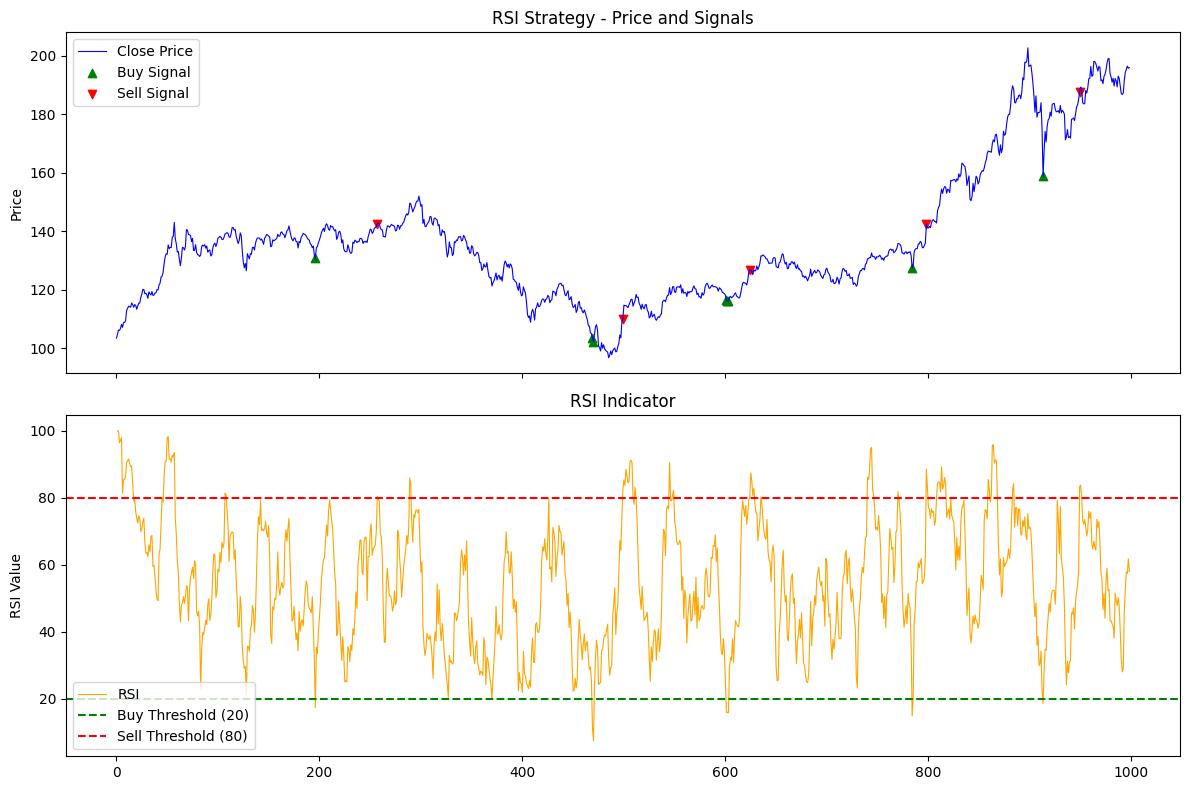


=== RSI Strategy Summary ===
Total Trades: 5
Cumulative Return: 55.81%
Average Return per Trade: 11.16%


,Close,RSI,Signal,Trade_Return,Cumulative_Return
0,103.40,NaN,None,None,0.0
1,104.60,100.000000,None,None,0.0
2,106.15,100.000000,None,None,0.0
3,106.05,96.491228,None,None,0.0
4,106.70,97.142857,None,None,0.0
...,...,...,...,...,...
994,194.30,52.695652,None,None,0.0
995,195.45,57.904085,None,None,0.0
996,196.50,57.450628,None,None,0.0
997,195.75,61.776062,None,None,0.0


In [8]:
rsi_analyzer = RSIAnalyzer(data=processor.data, period=14)
rsi_analyzer.apply_strategy(20,80)

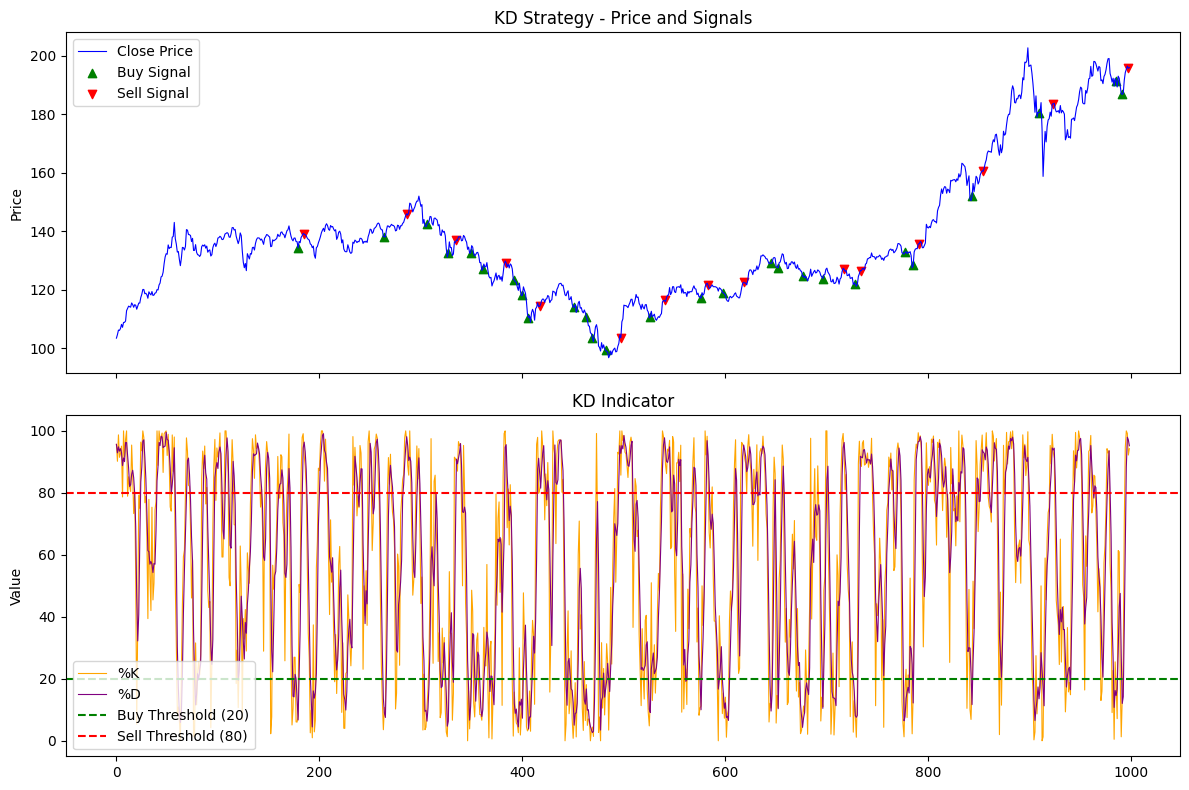


=== KD Strategy Summary ===
Total Trades: 15
Cumulative Return: 57.96%
Average Return per Trade: 3.86%


,Close,%K,%D,Signal,Trade_Return,Cumulative_Return
0,103.40,95.652174,95.652174,None,None,0.000000
1,104.60,90.196078,92.924126,None,None,0.000000
2,106.15,98.717949,94.855400,None,None,0.000000
3,106.05,91.463415,93.459147,None,None,0.000000
4,106.70,92.631579,94.270981,None,None,0.000000
...,...,...,...,...,...,...
994,194.30,94.685990,63.919720,None,None,0.000000
995,195.45,100.000000,88.309964,None,None,0.000000
996,196.50,99.173554,97.953181,None,None,0.000000
997,195.75,92.213115,97.128889,Sell,4.791221,57.960391


In [9]:
kd_analyzer = KDAnalyzer(data=processor.data)
kd_data = kd_analyzer.calculate_kd()
kd_analyzer.apply_strategy(buy_threshold=20, sell_threshold=80, plot=True)


=== MACD Strategy Summary ===
Total Trades: 36
Cumulative Return: 63.23%
Average Return per Trade: 1.76%


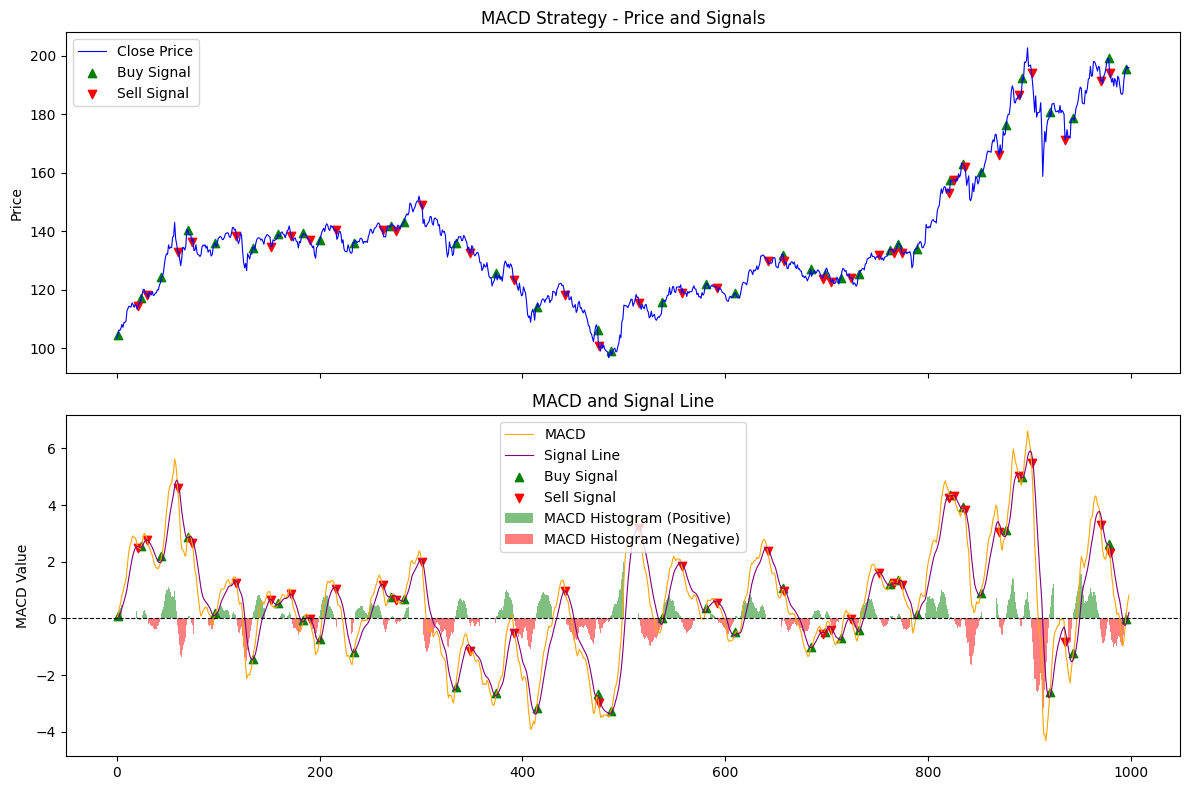

In [10]:
macd_analyzer = MACDAnalyzer(processor.data)
ma_data = macd_analyzer.calculate_macd()
macd_analyzer.apply_strategy()
macd_analyzer.plot_macd_with_signals()